<a href="https://colab.research.google.com/github/Kamran-imaz/CKD_DL/blob/main/Estimating_The_Risk_Of_Kidney_Disease_With_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents

---


1.   Importing and Installing Dependencies.
2.   Dataset Loading and Partitioning.
3.   Data - Preprocessing.
4.   PCA for Feature Selections.
5.   Neural Network Training and Testing.
6.   Inception V3 Training and Testing.
7.   Stacking the output of Custom ANN and SVC to Random Forest.
8.   Results.




# Importing and Installing Dependencies

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA


## Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [102]:
!pip install tensorflow

# Dataset Loading and Partitioning

In [172]:
df = pd.read_csv('./dataset/kidney_disease.csv')

In [173]:
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [175]:
## here we know that column id is not useful so we will drop that column
df = df.iloc[:,1:]
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [176]:
df.classification=df.classification.replace("ckd\t","ckd")
df = df.dropna(axis=0)

In [177]:
## Now let us divide the columns into dependent and independent variables(Data Partitioning).
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [178]:
X.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32,6700,3.9,yes,no,no,poor,yes,yes
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,9.5,29,12100,3.7,yes,yes,no,poor,no,yes
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,10.8,32,4500,3.8,yes,yes,no,poor,yes,no
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes


# Data - Preprocessing

In [179]:
## Let us do the data - preprocessing here....
## Now let us check wether we are having any null values in the 'y' field or not...
y.isnull().sum()
##Perfect we are not having any null values so now let us convert it into the numerical variable using string Indexer

0

In [180]:

indexer = LabelEncoder()

y = indexer.fit_transform(y.values.reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [181]:
y=pd.DataFrame(y)
y=y.rename(columns={0:'Classification'})
y.head()

,Classification
0,0
1,0
2,0
3,0
4,0


In [182]:
y.loc[:,'Classification'].unique()

array([0, 1])

In [183]:
y = y.rename(columns={0:'Classification'})
y.head()

,Classification
0,0
1,0
2,0
3,0
4,0


In [184]:
## Now Let us move onto the Dependent Variables first we will check which columns are having null values
print("Column Name","Total Rows","Total Missing Values")
for column in X.columns:
  print(f"{column} : {X.shape[0]} : {X.isnull().sum()[column]}")

Column Name Total Rows Total Missing Values
age : 158 : 0
bp : 158 : 0
sg : 158 : 0
al : 158 : 0
su : 158 : 0
rbc : 158 : 0
pc : 158 : 0
pcc : 158 : 0
ba : 158 : 0
bgr : 158 : 0
bu : 158 : 0
sc : 158 : 0
sod : 158 : 0
pot : 158 : 0
hemo : 158 : 0
pcv : 158 : 0
wc : 158 : 0
rc : 158 : 0
htn : 158 : 0
dm : 158 : 0
cad : 158 : 0
appet : 158 : 0
pe : 158 : 0
ane : 158 : 0


In [185]:
## first we will be converting the categorical variables in the X to numerical variables using
## Label Encoder....
for column in X.columns:
  if X[column].dtype == 'object':
    X[column] = indexer.fit_transform(X[column])

In [186]:
x_new = X

In [187]:
## Now let us check how many columns has the null value now
print("Column Name","Total Rows","Total Missing Values")
for column in x_new.columns:
  print(f"{column} : {x_new.shape[0]} : {x_new.isnull().sum()[column]}")

Column Name Total Rows Total Missing Values
age : 158 : 0
bp : 158 : 0
sg : 158 : 0
al : 158 : 0
su : 158 : 0
rbc : 158 : 0
pc : 158 : 0
pcc : 158 : 0
ba : 158 : 0
bgr : 158 : 0
bu : 158 : 0
sc : 158 : 0
sod : 158 : 0
pot : 158 : 0
hemo : 158 : 0
pcv : 158 : 0
wc : 158 : 0
rc : 158 : 0
htn : 158 : 0
dm : 158 : 0
cad : 158 : 0
appet : 158 : 0
pe : 158 : 0
ane : 158 : 0


# PCA for feature Selection


In [188]:

pca = PCA(n_components=2)

x_pca = pca.fit_transform(x_new)

loadings = pca.components_

loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])],
                           index=x_new.columns)
loadings_df = loadings_df.sort_values(by='PC1',ascending=True)
print(loadings_df.head(7))
loadings_df = loadings_df.sort_values(by='PC1',ascending=False)
print(loadings_df.head(7))

           PC1       PC2
rc   -0.077100 -0.086870
pcv  -0.064398 -0.057568
wc   -0.060344 -0.024257
sod  -0.043352 -0.059662
hemo -0.024757 -0.031673
pc   -0.003139 -0.003350
rbc  -0.002507 -0.000685
          PC1       PC2
bgr  0.905819 -0.412096
bu   0.393443  0.898772
age  0.075273  0.005481
bp   0.042634  0.057413
sc   0.024530  0.051039
al   0.013312  0.012150
su   0.008533 -0.002319


In [189]:
x_new.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane'],
      dtype='object')

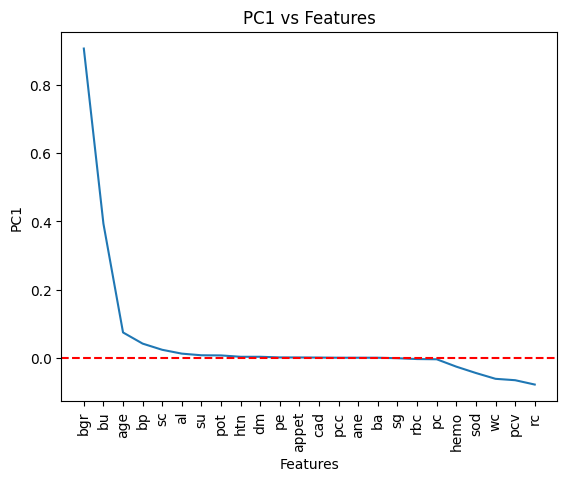

In [190]:
plt.plot(loadings_df.index,loadings_df['PC1'])
plt.axhline(y=0, color='r', linestyle='--', label='y = 0')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('PC1')
plt.title('PC1 vs Features')
plt.show()

In [191]:
## so what here i will do is....select those columns which greatly influence the variance value
## i.e either > 0 or < 0.

x_new = x_new[['bgr','bu','age','bp','sc','al','pc','hemo','sod','wc','pcv','rc']]

# Neural Networks Training and Testing

In [192]:
custom_ann = Sequential()

In [193]:
## Let us use cross validation inorder to perform very well for every set of the data....

from sklearn.model_selection import KFold

kf = KFold(n_splits=5,shuffle=True,random_state=42)

cv_custom_ann = []

for train_index,test_index in kf.split(x_new):
  x_train,x_test = x_new.iloc[train_index],x_new.iloc[test_index]
  y_train,y_test = y.iloc[train_index],y.iloc[test_index]
  ## Early Stopping
  early_stopping=EarlyStopping(
      monitor='val_loss',
      patience=10,
      restore_best_weights=True
  )
  ## This is Input Layer.
  custom_ann.add(Dense(1000,activation='relu'))
  custom_ann.add(Dropout(0.2))
  ## These are Hidden Layers.
  custom_ann.add(Dense(500,activation='relu'))
  custom_ann.add(Dropout(0.2))
  custom_ann.add(Dense(250,activation='relu'))
  custom_ann.add(Dropout(0.2))
  custom_ann.add(Dense(125,activation='relu'))
  custom_ann.add(Dropout(0.2))
  custom_ann.add(Dense(64,activation='relu'))
  custom_ann.add(Dropout(0.2))
  custom_ann.add(Dense(32,activation='relu'))
  custom_ann.add(Dropout(0.2))
  custom_ann.add(Dense(16,activation='relu'))
  custom_ann.add(Dropout(0.2))
  custom_ann.add(Dense(8,activation='relu'))
  custom_ann.add(Dropout(0.2))
  custom_ann.add(Dense(4,activation='relu'))
  custom_ann.add(Dropout(0.2))
  custom_ann.add(Dense(2,activation='relu'))
  custom_ann.add(Dropout(0.2))
  ## This is Output Layer.
  custom_ann.add(Dense(1,activation='sigmoid'))

  custom_ann.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  history_ann = custom_ann.fit(x_train,y_train,epochs=100,batch_size=32,validation_data=(x_test,y_test),callbacks=[early_stopping])
  loss, accuracy = custom_ann.evaluate(x_test, y_test)
  print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")
  cv_custom_ann.append(accuracy*100)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.6345 - loss: 2.5095 - val_accuracy: 0.7188 - val_loss: 0.6473
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6020 - loss: 2.3651 - val_accuracy: 0.7188 - val_loss: 0.6712
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5641 - loss: 2.3929 - val_accuracy: 0.7188 - val_loss: 0.6140
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5671 - loss: 1.1993 - val_accuracy: 0.7188 - val_loss: 0.6607
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5839 - loss: 1.3908 - val_accuracy: 0.7500 - val_loss: 0.7097
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5608 - loss: 1.9363 - val_accuracy: 0.3125 - val_loss: 0.6948
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6007 - loss: 1.4075 - val_accuracy: 0.9375 - val_loss: 0.6855
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5305 - loss: 1.4203 - val_accuracy: 0.1875 - val_loss

# SVM Training and Testing

In [194]:
kfolds = KFold(n_splits=5,shuffle=True,random_state=42)
svc_cv = []


In [195]:
for train_index,test_index in kfolds.split(x_new):
  x_train,x_test = x_new.iloc[train_index],x_new.iloc[test_index]
  y_train,y_test = y.iloc[train_index],y.iloc[test_index]


  # Create SVC Classifier
  svc = SVC(kernel='rbf', C=1.0, random_state=42)
  svc.fit(x_train, y_train)
  y_predict = svc.predict(x_test)
  accuracy = accuracy_score(y_test,y_predict)
  print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")
  svc_cv.append(accuracy*100)

Test Loss: 0.5456, Test Accuracy: 93.75%
Test Loss: 0.5456, Test Accuracy: 96.88%
Test Loss: 0.5456, Test Accuracy: 93.75%
Test Loss: 0.5456, Test Accuracy: 96.77%
Test Loss: 0.5456, Test Accuracy: 90.32%


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [196]:
y_train.shape

(127, 1)

# Stacking the output of Custom ANN and Inception V3 to Random Forest

In [197]:


# First let us Extract the features of both the custom ann and svc

custom_ann_features_train = custom_ann.predict(x_train)
custom_ann_features_test = custom_ann.predict(x_test)

## since here the values are continous so we need to convert it into either 0 or 1.

custom_ann_features_train = np.where(custom_ann_features_train > 0.5, 1, 0)
custom_ann_features_test = np.where(custom_ann_features_test > 0.5, 1, 0)

svc_features_train = svc.predict(x_train).reshape(-1, 1)
svc_features_test = svc.predict(x_test).reshape(-1, 1)

x_rf_train = np.concatenate((custom_ann_features_train, svc_features_train), axis=1)
x_rf_test = np.concatenate((custom_ann_features_test, svc_features_test), axis=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [198]:
svc_features_train

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [199]:
custom_ann_features_train

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [200]:
rf_classifier = RandomForestClassifier(n_estimators=100,random_state=42)
rf_classifier.fit(x_rf_train, y_train)
rf_predictions = rf_classifier.predict(x_rf_test)

rf_accuracy = accuracy_score(y_test,rf_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Results

**Results for Customized ANN**

In [201]:
print(f"The Average Accuracy of 5 Cross-Folds in custom_ann is: {np.mean(cv_custom_ann)}")

The Average Accuracy of 5 Cross-Folds in custom_ann is: 72.82258033752441


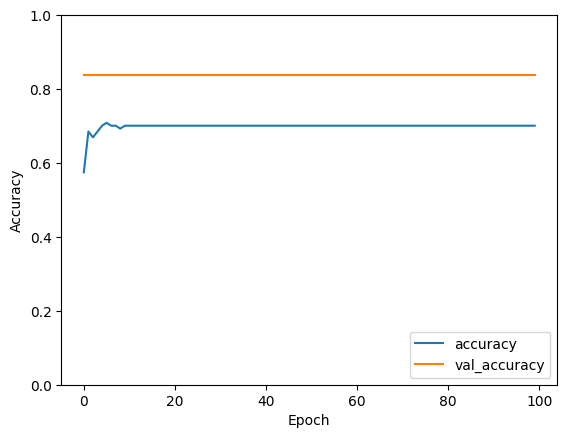

In [202]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [203]:
custom_ann.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_296 (Dense)                    │ (None, 1000)                │          13,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_265 (Dropout)                │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_297 (Dense)                    │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_266 (Dropout)                │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_298 (Dense)                    │ (None, 250)                 │         125,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_267 (Dropout)                │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_299 (Dense)                    │ (None, 125)                 │          31,375 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_268 (Dropout)                │ (None, 125)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_300 (Dense)                    │ (None, 64)                  │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_269 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_301 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_270 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_302 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_271 (Dropout)                │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_303 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_272 (Dropout)                │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_304 (Dense)                    │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_273 (Dropout)                │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_305 (Dense)                    │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_274 (Dropout)                │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_306 (Dense)                    │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 10,082,732 (38.46 MB)

 Trainable params: 3,360,910 (12.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,721,822 (25.64 MB)

**Results for Inception V3**

In [204]:
print(f"The Average Accuracy of 5 Cross-Folds in SVC is: {np.mean(svc_cv)}")

The Average Accuracy of 5 Cross-Folds in SVC is: 94.29435483870967


**Results after Stacking**

In [205]:
print(f"The Accuracy after Stacking using Random Forest is: {rf_accuracy*100}")

The Accuracy after Stacking using Random Forest is: 90.32258064516128
